# Vorbereitung

In [26]:
%env KERAS_BACKEND=theano
%env THEANO_FLAGS=floatX=float32,device=cpu

env: KERAS_BACKEND=theano
env: THEANO_FLAGS=floatX=float32,device=cpu


In [27]:
%load_ext autoreload
%autoreload 1
%aimport bb_behavior
%aimport bb_behavior.plot
%aimport bb_behavior.tracking
%aimport bb_behavior.tracking.pipeline

import bb_behavior
import bb_behavior.plot
import bb_behavior.tracking
import bb_behavior.tracking.pipeline

import pandas as pd
import time
import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

## Preprocessing step 1: convert the h264 to mp4

## Run

In [28]:
from bb_behavior.tracking.pipeline import get_default_pipeline
default_pipeline = None
default_pipeline = get_default_pipeline(localizer_threshold="0.50")

/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [29]:
from tqdm import tqdm_notebook # progress bar

import math
import numpy as np
from bb_tracking.data.constants import DETKEY
#from bb_tracking.tracking import score_id_sim_v
from bb_tracking.tracking import distance_orientations_v, distance_positions_v

from bb_behavior.tracking.pipeline import detect_markers_in_video
from bb_behavior.tracking.pipeline import track_detections_dataframe
from bb_behavior.tracking.pipeline import display_tracking_results

In [30]:
config = dict(tag_pixel_diameter=50,
              n_frames=None,
              confidence_filter_detections=0.08,
              confidence_filter_tracks=0.20,
              coordinate_scale=1.0,
              start_time=None,
              fps=10.0,
              cam_id=0,
              left_leaving_area = 0.30, # Prozente vom Bildschirmrand, zB. bei 1000px und 0.15 -> 0-150px
              right_leaving_area = 0.30,
              px_x_resolution_vid = 1944)


In [31]:
import time
import os

def filename_to_datestring(filname):
    """
    filename can be path
    """
    return os.path.split(filname)[-1].split('.')[0].split('_')[1]


def string_to_timestamp(datestring):
    """ 
    params
        string: format 2018-08-19-01-08-13
    output
        unix timestamp (float)
    """
    
    return time.mktime(time.strptime(datestring, "%Y-%m-%d-%H-%M-%S"))

def timestamp_to_string(timestamp):
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(timestamp))

In [32]:
# Einen Iterable speichern, der alle Videos in einem Iterable zur Verfügung stellt
# Diesen Iterable können wir dann in der nächsten Zelle mit tqdm schön durchlaufen
# nicht sehr performant --> O(n)
import os
base_directory = "../videos/"
paths = [i for i in os.listdir(base_directory) if i.endswith(".h264")]
for i in range(len(paths)):
    paths[i] = base_directory + paths[i]

In [33]:
# Hier passiert das eigentliche Tracken und speichern der Ergebnisse:
num_processed_videos = 0
video_data = dict()
frame_info = None
detections = None
bad_paths = []
videos_w_no_detection = ""


for path in tqdm_notebook(paths):
    start_time = config["start_time"]
    cam_id = config["cam_id"]
    try:
        num_processed_videos += 1

        frame_info, detections = detect_markers_in_video(path,
                                                      decoder_pipeline=default_pipeline,#pipeline=pipelines(),
                                                     tag_pixel_diameter=config["tag_pixel_diameter"],
                                                      n_frames=config["n_frames"],
                                                      fps=config["fps"],
                                                     progress="tqdm_notebook"
                                            )
        tracks = track_detections_dataframe(detections,
                                            tracker="tracker.det_score_fun.frag_score_fun.dill",
                                            confidence_filter_detections=config["confidence_filter_detections"],
                                           confidence_filter_tracks=config["confidence_filter_tracks"],
                                            coordinate_scale=config["coordinate_scale"]
                                           )
        date_string = filename_to_datestring(path)
        tracks['video'] = date_string
        video_data[path] = (frame_info, detections, tracks)
    except ValueError as err: #tritt auf, wenn Video leer ist. In diesem Fall: überspringe video
        try:
            videos_w_no_detection = videos_w_no_detection + path + "\n"
            bad_paths.append(path)
            # wir arbeiten später nochmal mit paths, daher müssen das leere löschen, weil sonst
            # in video_data kein zugehöriger Value zu Key = file zu finden ist.
        except KeyError as err:
            continue
    except Exception as err:
        print(err)
        raise
    # only first vid: break

for bad_path in bad_paths:
    paths.remove(bad_path)

/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might le

In [34]:
#gebe Videos aus, in denen keine Bienen gefunden wurden
if videos_w_no_detection:
    print("In the following file(s) were no bees detected:")
    print(videos_w_no_detection)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Found 40 detections belonging to 1 unique tracks and 1 individuals.


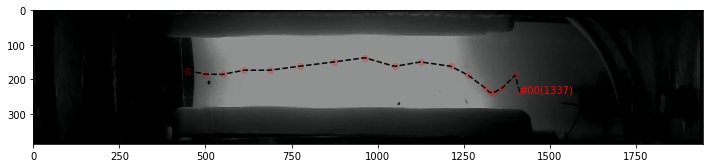

Detection/track statistics:


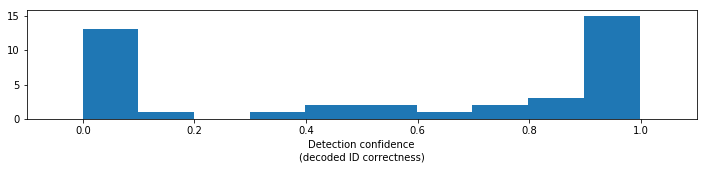

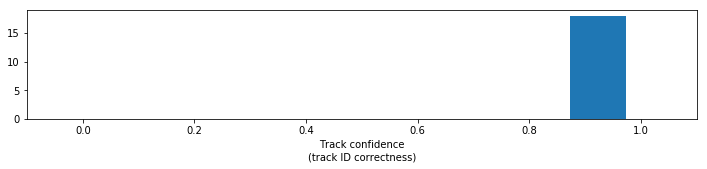

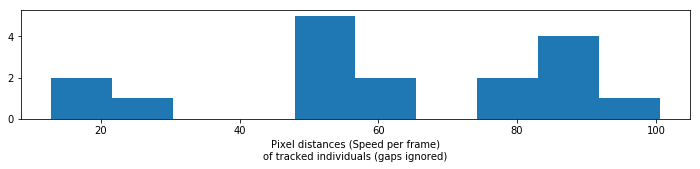

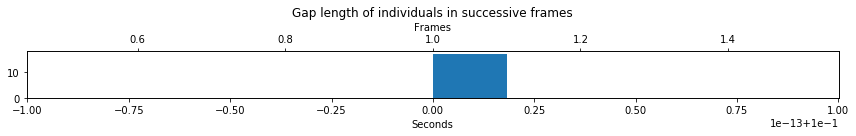

Individual statistics:


ModuleNotFoundError: No module named 'cairocffi'

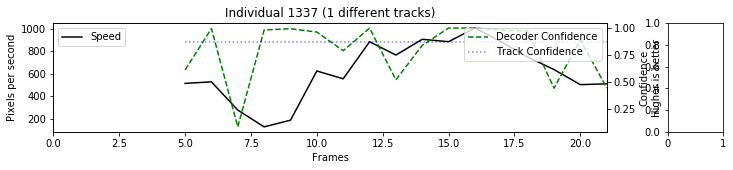

In [35]:
#video_data["file"][0] --> frame-info, [1] --> detections, [2] --> tracks
for path in paths:
    display_tracking_results(path, video_data[path][0], video_data[path][1], video_data[path][2])

In [ ]:
video_data[paths[0]][2]

# Modify data to default for all Algorithms / Save detection to .csv

In [36]:
tracks = [video_data[paths[x]][2] for x in range(len(paths))]
tracks = pd.concat(tracks,ignore_index=True)
tracks = tracks.drop(columns=["localizerSaliency", "beeID", "camID", "frameIdx"])

In [37]:
with open("tracks.csv", "w") as f:
    tracks.to_csv(f)

In [ ]:
tracks

In [72]:
# ERGEBNIS-DICT, kann mit pd.DataFrame(data=bee_moves) in DataFrame gewandelt werden
# "bee_id":[int], "time_in":[String], "os_in":[Float], "time_out":[String],
# "os_out":[Float], "in_direction":[{"left", "right"}], "out_direction":[{"left", "right"}]
bee_moves = {"bee_id":[], "time_in":[], "os_in":[], "time_out":[], "os_out":[], "in_direction":[], "out_direction":[]}

# Algorithmus 1: Baseline

In [73]:
from math import pi
import csv
""" Vorgehen:
Für jedes Video
- Prüfe, wo sich die Biene beim ersten erkannten Erscheinen aufhält
    - Ordne die Position in left, right oder middle ein
- Prüfe, wo sich die Biene beim letzten erkannten Erscheinen aufhält
    - Ordne die Position in left, right oder middle ein
Wenn sich Biene in der Mitte befindet, starte neue Routine, die links oder rechts zuordnet
Daraus kann nun abgeleitet werden, wo die Biene reingekommen ist und wo sie rausgegangen ist.
"""

# Routine, wenn Biene in der Mitte
# Betrachte zRotation, das ist die Richtung in die die Biene guckt (in Bogenmaß)
# gebe diese Richtung aus
def middle_classifier(zRotation):
    if zRotation > abs(pi/2):
        return "left"
    else:
        return "right"

def baseline_alg_classify_bee():
    video_groups = tracks.groupby(["video"])
    for group_name, df_group in video_groups:
        movement = dict()
        recording_begin = group_name

        # Finde start- und endposition
        for row in df_group.itertuples():
            bee_id = row[9]
            xpos = row[2]
            ypos = row[3]
            zRotation = row[4]
            timestamp = row[5]

            if bee_id in movement.keys():
                if not movement[bee_id]: #hier wird value betrachtet
                    # Aufbau movement[bee_id] = 
                    # [(xpos_anfang, ypos_anfang), (xpos_ende, ypos_ende), time_in bzw. time_out, os_in, os_out, z_start, z_end]
                    movement[bee_id] = [(xpos, ypos), (xpos, ypos), recording_begin, timestamp, timestamp, zRotation, zRotation]
                else: #spätere detection in Video -> aktualisiere
                    movement[bee_id][1] = (xpos, ypos)
                    movement[bee_id][4] = timestamp
                    movement[bee_id][6] = zRotation
            else:
                movement[bee_id] = [(xpos, ypos), (xpos, ypos), recording_begin, timestamp, timestamp, zRotation, zRotation]

        def is_left(xpos):
            return xpos <= config["left_leaving_area"]*config["px_x_resolution_vid"]
        def is_right(xpos):
            return xpos >= config["px_x_resolution_vid"] - config["right_leaving_area"]*config["px_x_resolution_vid"]

        # Setze labels, entferne andere Daten
        for bee_id in movement.keys():
            start_pos = movement[bee_id][0]
            end_pos = movement[bee_id][1]
            z_start = movement[bee_id][-2]
            z_end = movement[bee_id][-1]
            labels = dict()

            # Eintrittsseite festlegen
            if is_left(start_pos[0]):
                labels["in_direction"] = "left"
            elif is_right(start_pos[0]):
                labels["in_direction"] = "right"
            else:
                labels["in_direction"] = middle_classifier(z_start)

            # Austrittsseite festlegen
            if is_left(end_pos[0]):
                labels["out_direction"] = "left"
            elif is_right(end_pos[0]):
                labels["out_direction"] = "right"
            else:
                labels["out_direction"] = middle_classifier(z_end)

            bee_moves["bee_id"].append(bee_id)
            bee_moves["in_direction"].append(labels["in_direction"])
            bee_moves["out_direction"].append(labels["out_direction"])
            bee_moves["time_in"].append(movement[bee_id][2])
            bee_moves["time_out"].append(movement[bee_id][2])
            bee_moves["os_in"].append(movement[bee_id][3])
            bee_moves["os_out"].append(movement[bee_id][4])
                        

In [74]:
# Ausgeben
baseline_alg_classify_bee()
bee_moves = pd.DataFrame(data=bee_moves)
# write to MaschineLearnedData.csv
bee_moves.to_csv('MaschineLearnedData.csv', encoding='utf-8', index=False)
bee_moves
 

,bee_id,time_in,os_in,time_out,os_out,in_direction,out_direction
0,1337.0,2018-08-19-17-42-21,0.4,2018-08-19-17-42-21,2.1,right,left


# Vergleichsfunktion Algorithmus mit Labels

In [ ]:
# gelabelted Datensatz einlesen:
labeled_data = pd.read_csv("labels.csv")
labeled_data = labeled_data.filter(["bee_id", "video", "in_direction", "out_direction"])

# nur ein Video betrachten:
#labeled_data = labeled_data[labeled_data["video"] == "e00_2018-08-19-12-34-35.h264"].drop(columns=["video"])

# Vergleichen

for bee_id in results["bee_id"]:
    if results[bee_id] in labeled_data["bee_id"]:
        if results[bee_id]
    